In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import zipfile

from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 20,10

#from category_encoders import TargetEncoder

In [40]:
#esse comando funciona melhor no spyder ou vs code
fantasy_zip = zipfile.ZipFile(r'C:\Users\gustavo.aguiar\Downloads\archive__.zip')
fantasy_zip.extractall()
fantasy_zip.close()

In [41]:
# Exibição das 5 Primeiras Linhas do DataFrame
df = pd.read_csv('microdados.csv', index_col=)
df.head()

,ano,sigla_uf,id_municipio,bairro_revenda,cep_revenda,endereco_revenda,cnpj_revenda,nome_estabelecimento,bandeira_revenda,data_coleta,produto,unidade_medida,preco_compra,preco_venda
0,2004,MG,3170701,CENTRO,37002-040,"PRACA MARECHAL FLORIANO,100",86.437.472/0001-21,SANTA LUIZA DERIVADOS DE PETROLEO LTDA,BRANCA,2004-05-10,etanol,R$/litro,0.9367,1.280
1,2004,SP,3554102,VILA SAO JOSE,12070-590,"AVENIDA DOM DUARTE LEOPOLDO E SILVA,501",03.842.497/0001-83,AUTO POSTO ANA ROSA TAUBATE LTDA - EPP,ALE COMBUSTÍVEIS,2004-05-10,gasolina,R$/litro,1.7020,1.899
2,2004,SP,3554102,PARQUE SAO LUIS,12061-600,"RUA PADRE FISCHER,1487",01.583.271/0001-80,ABOU HALA & IBANHES AUTO POSTO LTDA.,BRANCA,2004-05-10,diesel,R$/litro,NaN,1.399
3,2004,SP,3554102,PARQUE SAO LUIS,12061-600,"RUA PADRE FISCHER,1487",01.583.271/0001-80,ABOU HALA & IBANHES AUTO POSTO LTDA.,BRANCA,2004-05-10,etanol,R$/litro,0.5878,0.799
4,2004,SP,3554102,PARQUE SAO LUIS,12061-600,"RUA PADRE FISCHER,1487",01.583.271/0001-80,ABOU HALA & IBANHES AUTO POSTO LTDA.,BRANCA,2004-05-10,gasolina,R$/litro,1.6218,1.899


In [42]:
df.shape

(26514824, 14)

In [43]:
# Dropando a coluna de Id do município
df.drop(['id_municipio','cnpj_revenda','cep_revenda','endereco_revenda','data_coleta','nome_estabelecimento'],axis=1,inplace=True)

In [44]:
df.dtypes

ano                   int64
sigla_uf             object
bairro_revenda       object
bandeira_revenda     object
produto              object
unidade_medida       object
preco_compra        float64
preco_venda         float64
dtype: object

In [46]:
unique_values = []
# Verificando os valores únicos por coluna
[(unique_values.append(str(df[coluna].nunique())),print(coluna+' possui '+str(df[coluna].nunique())+' valores únicos')) for coluna in df.columns]

ano possui 18 valores únicos
sigla_uf possui 27 valores únicos
bairro_revenda possui 19689 valores únicos
bandeira_revenda possui 268 valores únicos
produto possui 9 valores únicos
unidade_medida possui 3 valores únicos
preco_compra possui 106753 valores únicos
preco_venda possui 8048 valores únicos


[(None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [47]:
# Verificando a existência de possíveis valores ausentes
df.isnull().sum()

ano                        0
sigla_uf                   0
bairro_revenda         69362
bandeira_revenda           1
produto                    0
unidade_medida             1
preco_compra        14419107
preco_venda                1
dtype: int64

In [48]:
#retira valor ausente
df.dropna(inplace=True)

In [50]:
df_describe = df.describe().T
df_describe

,count,mean,std,min,25%,50%,75%,max
ano,12060097.0,2010.234978,4.546526,2004.0000,2006.0000,2009.0000,2014.0000,2020.00
preco_compra,12060097.0,6.259457,11.036330,0.3257,1.6817,2.1364,2.7347,94.50
preco_venda,12060097.0,7.935375,14.623714,0.5900,1.8990,2.4690,3.1500,115.99


In [54]:
# Definindo as variáveis numéricas e categóricas
num_attributes = df.select_dtypes(include=['int64', 'float64'])
cat_attributes = df.select_dtypes(exclude=['int64', 'float64'])

print(num_attributes)
print(cat_attributes)

           ano  preco_compra  preco_venda
0         2004        0.9367        1.280
1         2004        1.7020        1.899
3         2004        0.5878        0.799
4         2004        1.6218        1.899
9         2004       24.0000       29.000
...        ...           ...          ...
25706241  2020        3.9481        4.660
25706242  2020        2.7727        3.280
25706243  2020        3.0190        3.620
25706244  2020        2.2082        2.499
25706261  2020        2.2598        2.599

[12060097 rows x 3 columns]
         sigla_uf   bairro_revenda  bandeira_revenda   produto unidade_medida
0              MG           CENTRO            BRANCA    etanol       R$/litro
1              SP    VILA SAO JOSE  ALE COMBUSTÍVEIS  gasolina       R$/litro
3              SP  PARQUE SAO LUIS            BRANCA    etanol       R$/litro
4              SP  PARQUE SAO LUIS            BRANCA  gasolina       R$/litro
9              SP                             BRANCA       glp        R$/13kg

In [62]:
df_skewness  = pd.DataFrame(num_attributes.skew(),columns=['assimetria'])
df_kurtosis  = pd.DataFrame(num_attributes.kurtosis(),columns=['kurtosis'])
df_median    = pd.DataFrame(num_attributes.median(),columns=['median'])
df_intervalo = pd.DataFrame(num_attributes.max() - num_attributes.min(),columns=['range'])

In [63]:
df_descritive_statistics = pd.concat([df_describe,df_skewness,df_kurtosis,df_median,df_intervalo],axis=1)
df_descritive_statistics

,count,mean,std,min,25%,50%,75%,max,assimetria,kurtosis,median,range
ano,12060097.0,2010.234978,4.546526,2004.0000,2006.0000,2009.0000,2014.0000,2020.00,0.449198,-0.934964,2009.0000,16.0000
preco_compra,12060097.0,6.259457,11.036330,0.3257,1.6817,2.1364,2.7347,94.50,2.606155,6.292515,2.1364,94.1743
preco_venda,12060097.0,7.935375,14.623714,0.5900,1.8990,2.4690,3.1500,115.99,2.614433,6.212471,2.4690,115.4000


array([[<AxesSubplot:title={'center':'ano'}>,
        <AxesSubplot:title={'center':'preco_compra'}>],
       [<AxesSubplot:title={'center':'preco_venda'}>, <AxesSubplot:>]],
      dtype=object)

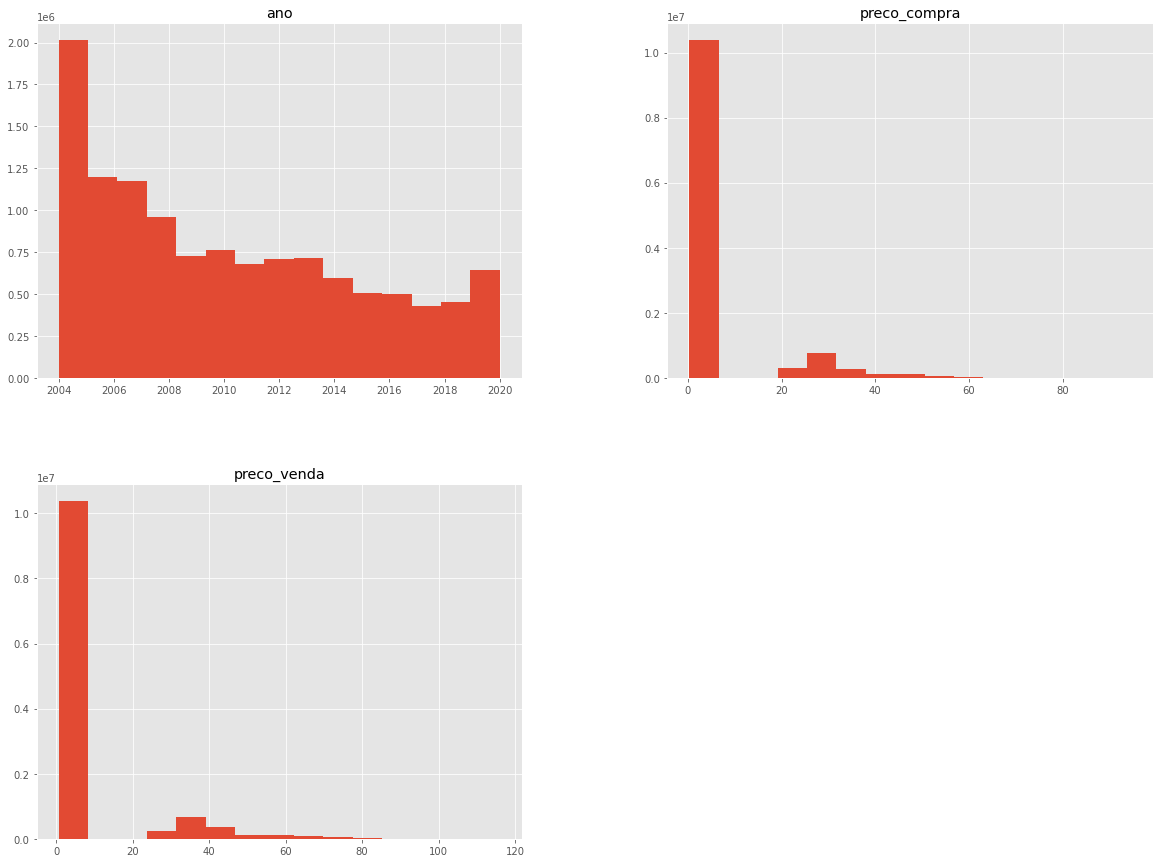

In [74]:
df.hist(bins=15,figsize=(20,15))


<AxesSubplot:xlabel='ano'>

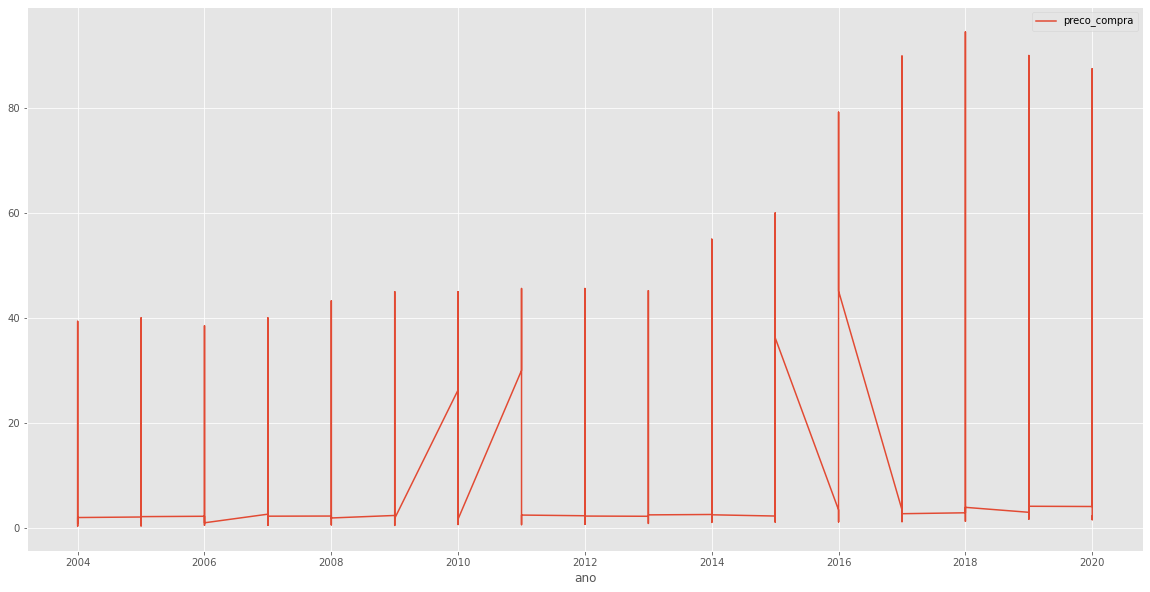

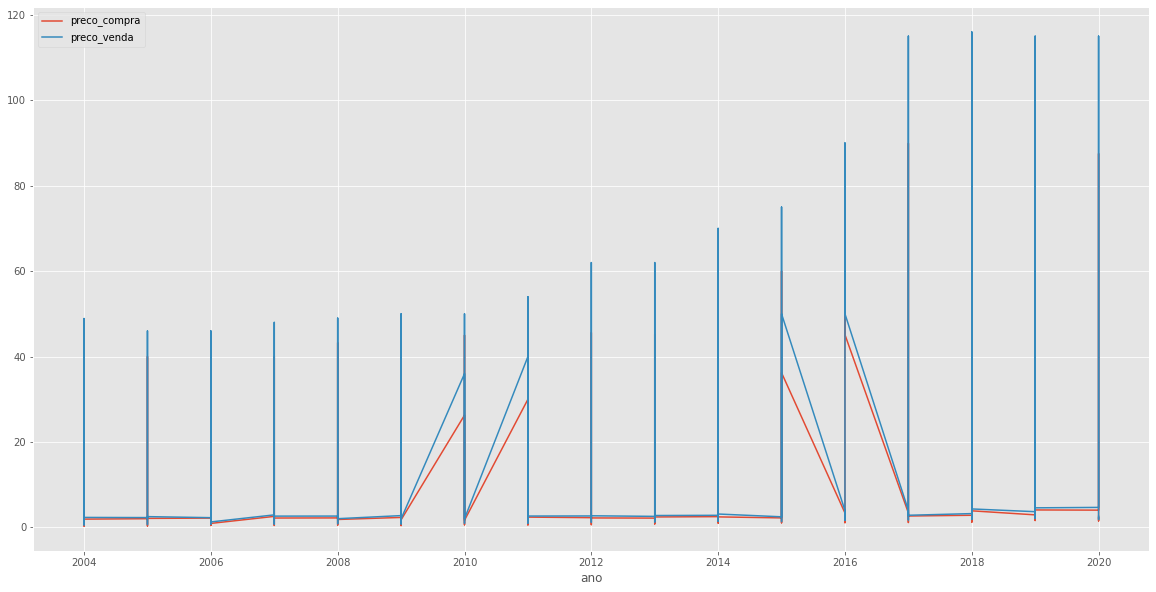

In [82]:
preco_compra = num_attributes.set_index('ano').drop('preco_venda', axis=1)
preco_compra.head(4)
preco_compra.plot()

num_attributes.set_index('ano').plot()

In [83]:
produtos = sorted(df.produto.unique())
produtos

['diesel', 'diesel s10', 'diesel s50', 'etanol', 'gasolina', 'glp', 'gnv']

In [84]:
# Verificar a quantidade de anos que os dados de cada tipo de produto abrangem 
print('dielsel: ',df.ano[df.produto == 'diesel'].nunique())
print('dielsel s10: ',df.ano[df.produto == 'diesel s10'].nunique())
print('dielsel s50: ',df.ano[df.produto == 'diesel s50'].nunique())
print('etanol: ',df.ano[df.produto == 'etanol'].nunique())
print('gasolina: ',df.ano[df.produto == 'gasolina'].nunique())
print('glp: ',df.ano[df.produto == 'glp'].nunique())
print('gnv: ',df.ano[df.produto == 'gnv'].nunique())

dielsel:  17
dielsel s10:  9
dielsel s50:  1
etanol:  17
gasolina:  17
glp:  17
gnv:  17


In [86]:
# Cálculo do preço médio de compra e de venda por tipo de produto
df_preco_compra = df.groupby('produto').preco_compra.mean().sort_values().reset_index()
df_preco_venda  = df.groupby('produto').preco_venda.mean().sort_values().reset_index()


# Identificando a unidade de medida de cada um dos tipos de produto
df_unidade_medida = df.groupby('produto').unidade_medida.unique().reset_index()

# Agrupando os DataFrames
df_produto = df_preco_compra.merge(df_preco_venda,on='produto').merge(df_unidade_medida,on='produto')

# Criando nova coluna com a diferença entre os preços
df_produto['lucro'] = df_produto.preco_venda - df_produto.preco_compra

# Criando nova coluna com a margem de lucro
df_produto['margem_lucro'] = 100*df_produto.lucro/df_produto.preco_venda

# Visualizar o DataFrame
df_produto


,produto,preco_compra,preco_venda,unidade_medida,lucro,margem_lucro
0,gnv,1.125563,1.614753,[R$/m3],0.489191,30.295065
1,etanol,1.627610,1.924001,[R$/litro],0.296391,15.404928
2,diesel,1.875067,2.110942,[R$/litro],0.235875,11.173913
3,diesel s50,1.934734,2.172194,[R$/litro],0.237460,10.931802
4,gasolina,2.440622,2.823537,[R$/litro],0.382915,13.561524
5,diesel s10,2.800803,3.183383,[R$/litro],0.382580,12.018047
6,glp,32.210910,42.246120,[R$/13kg],10.035210,23.754158


In [87]:
# Cálculo do preço médio de compra e de venda por tipo de produto
df_preco_compra = df.groupby(['produto','ano']).preco_compra.mean().reset_index().sort_values(by=['produto','ano'])
df_preco_venda  = df.groupby(['produto','ano']).preco_venda.mean().reset_index().sort_values(by=['produto','ano']).drop(['ano','produto'],axis=1)

# Agrupando os DataFrames
df_produto_ano = pd.concat([df_preco_compra,df_preco_venda],axis=1)

# Criando nova coluna com a diferença entre os preços
df_produto_ano['lucro'] = df_produto_ano.preco_venda - df_produto_ano.preco_compra

# Criando nova coluna com a margem de lucro
df_produto_ano['margem_lucro'] = 100*df_produto_ano.lucro/df_produto_ano.preco_venda

# Visualizar o DataFrame
df_produto_ano

,produto,ano,preco_compra,preco_venda,lucro,margem_lucro
0,diesel,2004,1.338026,1.516628,0.178602,11.776274
1,diesel,2005,1.549685,1.737849,0.188164,10.827404
2,diesel,2006,1.691188,1.884697,0.193509,10.267379
3,diesel,2007,1.691489,1.876851,0.185361,9.876196
4,diesel,2008,1.841343,2.037682,0.196339,9.635409
...,...,...,...,...,...,...
90,gnv,2016,1.591210,2.293314,0.702104,30.615241
91,gnv,2017,1.673769,2.400115,0.726346,30.262971
92,gnv,2018,1.949797,2.804422,0.854625,30.474189
93,gnv,2019,2.386468,3.277294,0.890826,27.181752


In [88]:
# DataFrames para cada tipo de produto
diesel = df_produto_ano[df_produto_ano.produto == 'diesel']
diesel_s10 = df_produto_ano[df_produto_ano.produto == 'diesel s10']
etanol = df_produto_ano[df_produto_ano.produto == 'etanol']
gasolina = df_produto_ano[df_produto_ano.produto == 'gasolina']
glp = df_produto_ano[df_produto_ano.produto == 'glp']
gnv = df_produto_ano[df_produto_ano.produto == 'gnv']

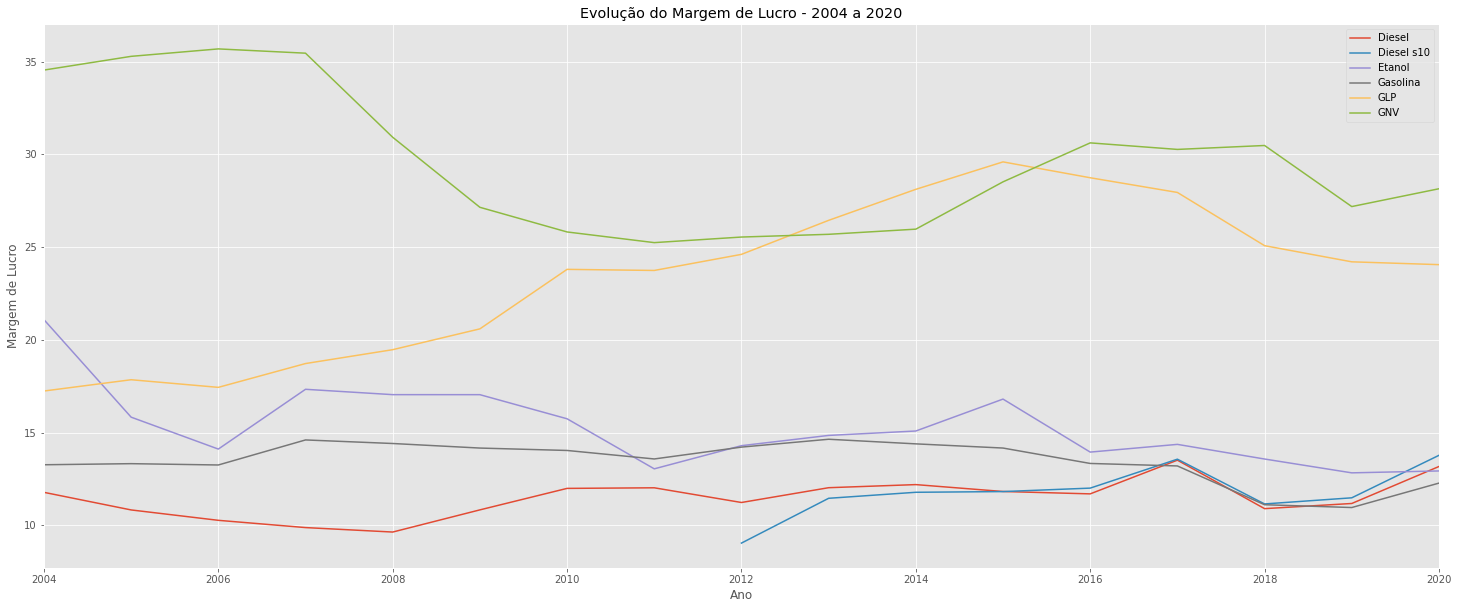

In [89]:
# Plotagem dos gráficos
plt.figure(figsize=(25,10))
sns.lineplot(data=diesel,x='ano',y='margem_lucro',label='Diesel');
sns.lineplot(data=diesel_s10,x='ano',y='margem_lucro',label='Diesel s10');
sns.lineplot(data=etanol,x='ano',y='margem_lucro',label='Etanol');
sns.lineplot(data=gasolina,x='ano',y='margem_lucro',label='Gasolina');
sns.lineplot(data=glp,x='ano',y='margem_lucro',label='GLP');
sns.lineplot(data=gnv,x='ano',y='margem_lucro',label='GNV');
plt.xlabel('Ano')
plt.ylabel('Margem de Lucro')
plt.title('Evolução do Margem de Lucro - 2004 a 2020')
plt.xlim([2004,2020])
plt.legend()

Text(0.5, 1.0, 'Boxplot: Preço de Compra x produto')

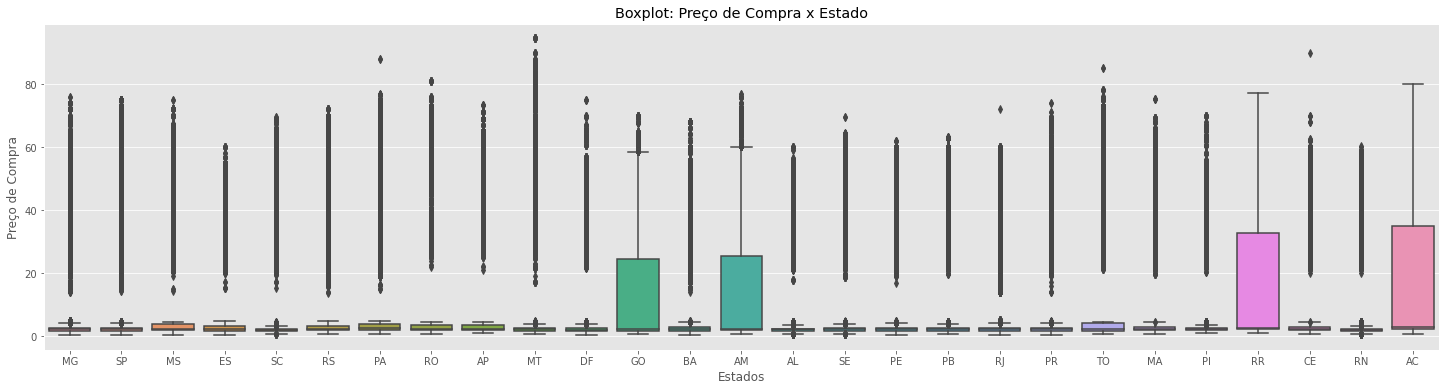

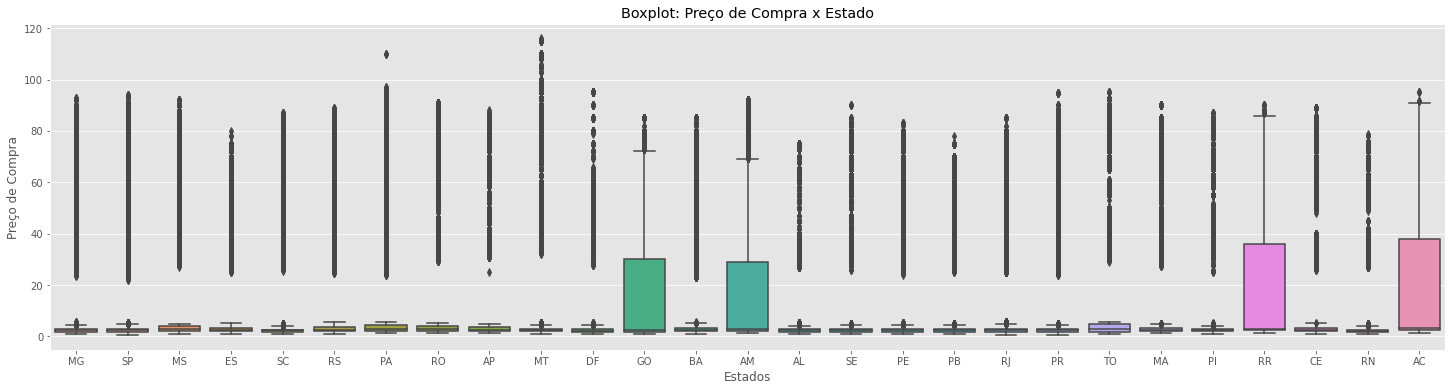

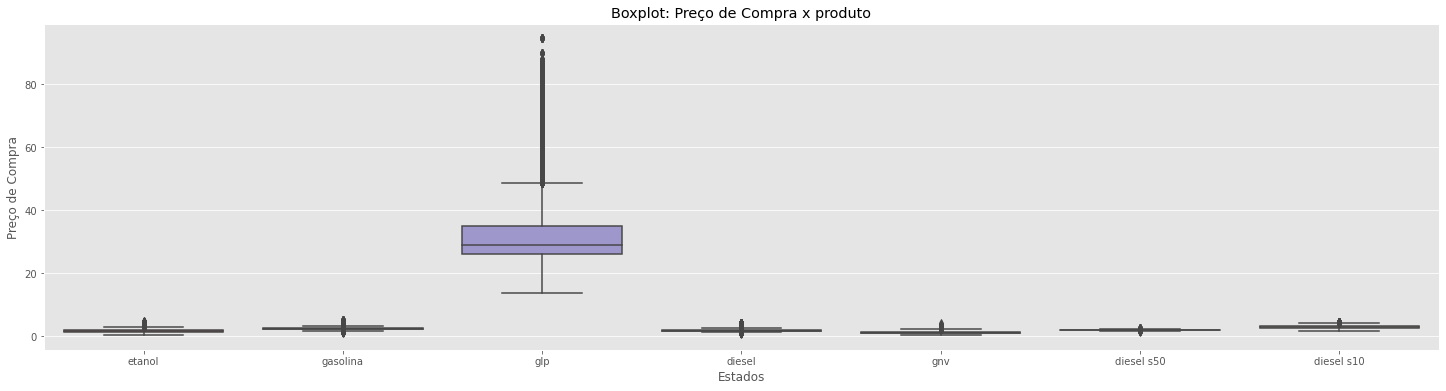

In [92]:
# Afim de visualizar a distribuição dos dados para cada variável e identificar possíveis outliers
plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_compra',x='sigla_uf')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra')
plt.title('Boxplot: Preço de Compra x Estado')


plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_venda',x='sigla_uf')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra')
plt.title('Boxplot: Preço de Compra x Estado')



plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_compra',x='produto')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra')
plt.title('Boxplot: Preço de Compra x produto')



In [93]:
df_precos_estados = df.groupby(['sigla_uf','produto']).agg({'preco_compra':'mean','preco_venda':'mean'}).reset_index()

# Criando nova coluna com a diferença entre os preços
df_precos_estados['lucro'] = df_precos_estados.preco_venda - df_precos_estados.preco_compra

# Criando nova coluna com a margem de lucro
df_precos_estados['margem_lucro'] = 100*df_precos_estados.lucro/df_precos_estados.preco_venda

df_precos_estados_diesel = df_precos_estados[df_precos_estados.produto == 'diesel'][['sigla_uf','margem_lucro']].sort_values(by='margem_lucro',ascending=False)

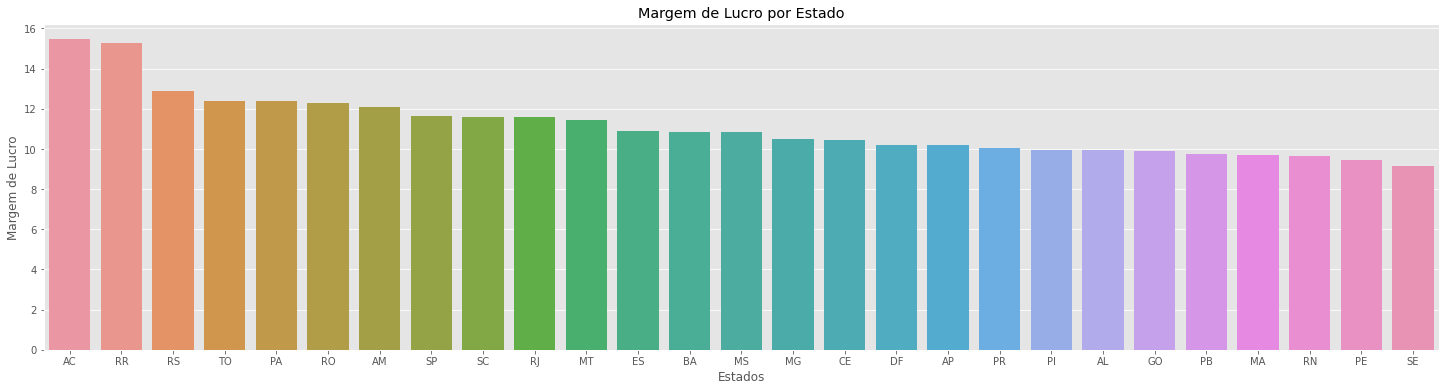

In [94]:
plt.figure(figsize=(25,6))
plt.title('Margem de Lucro por Estado');
sns.barplot(data=df_precos_estados_diesel,x='sigla_uf',y='margem_lucro')
plt.xlabel('Estados')
plt.ylabel('Margem de Lucro');

Text(0, 0.5, 'Preço de Venda')

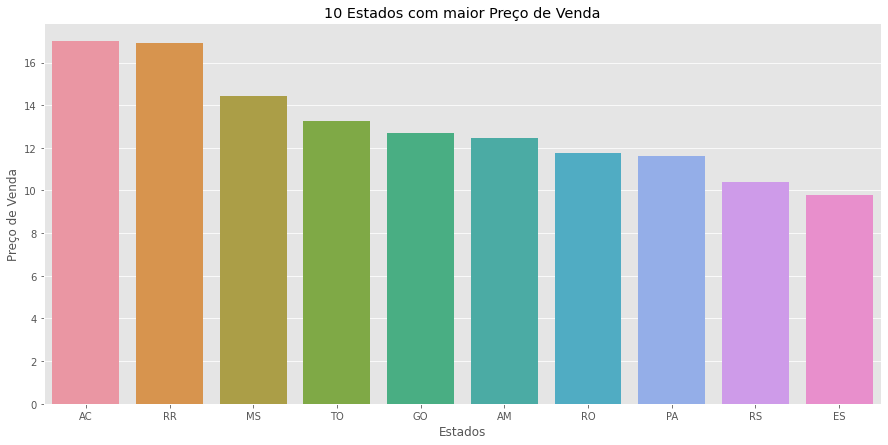

In [96]:
plt.figure(figsize=(15,7))
df_preco_venda_top10 = df.groupby('sigla_uf').preco_venda.mean().reset_index().sort_values(by='preco_venda',ascending=False)[:10]
sns.barplot(data=df_preco_venda_top10,x='sigla_uf',y='preco_venda').set_title('10 Estados com maior Preço de Venda')
plt.xlabel('Estados')
plt.ylabel('Preço de Venda')

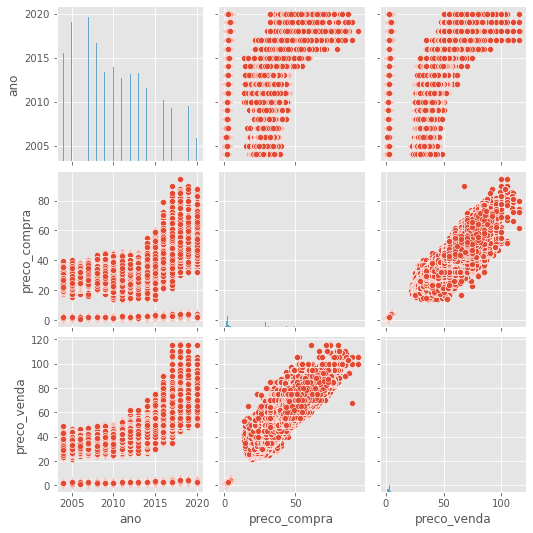

In [97]:
sns.pairplot(df)
plt.show()

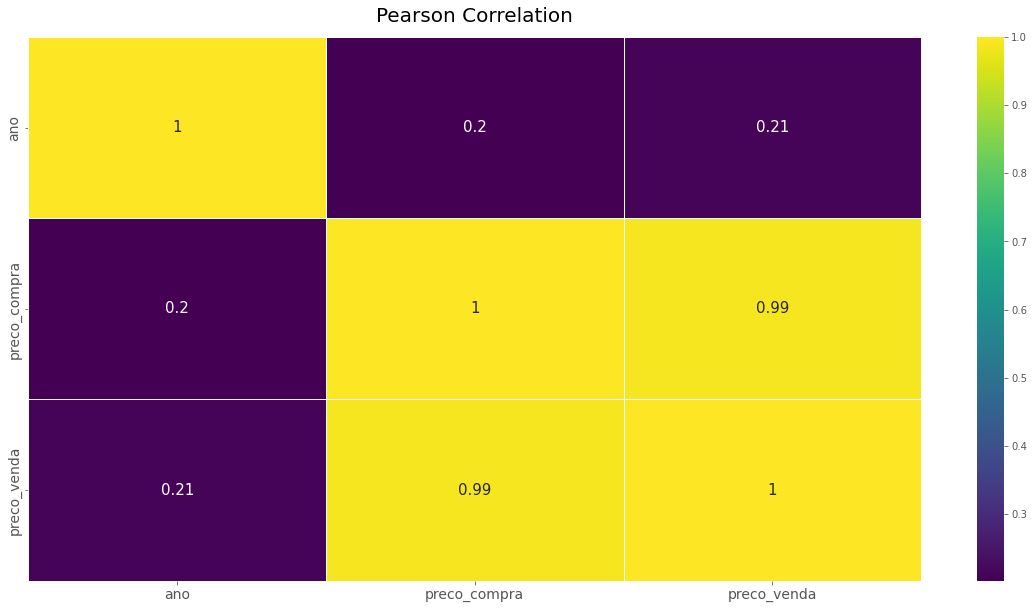

In [98]:
# Visualizar a correlação entre cada variável utilizando a correlação de Pearson 
_ = plt.figure(figsize = (20,10))
res = sns.heatmap(df.corr(), vmax = 1, linewidths = 0.9, cmap = 'viridis',annot_kws={"size": 15},annot=True)
_ = plt.title('Pearson Correlation', fontsize = 20, pad = 15)
_ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
_ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

In [99]:
# Cálculo do primeiro quartil (Q1)
Q1 = np.percentile(df['preco_venda'], 25,
                   interpolation = 'midpoint')

# Cálculo do terceiro quartil (Q3) 
Q3 = np.percentile(df['preco_venda'], 75,
                   interpolation = 'midpoint')

# Cálculo do IQR (Intervalo Interquartil)
IQR = Q3 - Q1

# Cálculo do limite superior
upper = Q3 +1.5*IQR

# Cálculo do limite inferior
lower = Q1 - 1.5*IQR
 
# Removendo outliers
df = df[df.preco_venda <= upper]
df = df[df.preco_venda >= lower]

df_sem_outliers = df.copy()
df_sem_outliers.drop('unidade_medida',axis=1,inplace=True)

In [107]:
df_sem_outliers

,ano,sigla_uf,bairro_revenda,bandeira_revenda,produto,preco_compra,preco_venda
0,2004,MG,CENTRO,BRANCA,etanol,0.9367,1.280
1,2004,SP,VILA SAO JOSE,ALE COMBUSTÍVEIS,gasolina,1.7020,1.899
3,2004,SP,PARQUE SAO LUIS,BRANCA,etanol,0.5878,0.799
4,2004,SP,PARQUE SAO LUIS,BRANCA,gasolina,1.6218,1.899
16,2004,SP,VILA SAO JOSE,ALE COMBUSTÍVEIS,etanol,0.5339,0.699
...,...,...,...,...,...,...,...
25706241,2020,MS,CENTRO,RAIZEN,gasolina,3.9481,4.660
25706242,2020,MS,CENTRO,RAIZEN,etanol,2.7727,3.280
25706243,2020,MS,CENTRO,RAIZEN,diesel,3.0190,3.620
25706244,2020,SP,CASTELO,RAIZEN,etanol,2.2082,2.499
